# Fine-Tuning Large Language Models for Sentiment Analysis

<i>COMET Team</i></br> Irene Berezin  
2024-07-29

------------------------------------------------------------------------

Sentiment analysis is a useful tool for gathering a high-level
understanding of the emotions expressed in written text. For instance, a
finance firm may wish to gather information about market sentiment
pertaining to bitcoin. It would do so by first gathering a corpus of
tweets and posts from various sources online, and analysing it by
comparing posts to a special kind of dictionary, called a *sentiment
dictionary*, which contains a list of words and their predetermined
sentiment. This process is called *lexicon-based sentiment analysis*. If
you’d like to learn more about lexicon-based sentiment analysis, you can
consult [this notebook]().

The issue with lexicon-based sentiment analysis, is that especially in
modern times, it can be inaccurate: Dictionary based sentiment analysis
is *context ignorant*, meaning that it struggles with things such as
sarcasm and irony, as well as mixed emotions $^{[1]}$. Additionally,
language is constantly changing: for instance, the term “bad” is
traditionally associated with negative sentiment, but often holds a
different, positive connotation on the internet.

For these reasons, this notebook outlines a novel method of sentiment
analysis, which uses large language models (LLMs) to conduct sentiment
analysis on a given dataset. In particular, this notebook outlines the
process of *fine-tuning* an LLM for the explicit purpose of sentiment
analysis.

## 0. Prerequisites

### 0.1 Prior Knowledge

-   A basic understanding of coding in Python.

-   A basic understanding of linear algebra is useful for the theory,
    but not required for running this notebook. \### 0.2
    Hardware/Software requirements

-   **This notebook requires access to NVIDIA GPU, with at least 12
    gigabites of VRAM. Additionally, you will need at least 12 gigabites
    of RAM.** If you are running on a mac, or your computer doesn’t meet
    the above requirements, consider running this notebook using [google
    collab](https://colab.research.google.com/).

<b>Warning:</b> For the reason outlined above, this notebook <b>cannot
be run on Sygyzy</b>, which limits students to two gigabites of memory.
See the installation instructions for installing locally on how to run
this notebook directly on your computer.

-   Conda/miniconda installed on your device.
-   If not on Collab, either a local instance of jupyterlab, or an IDE.

## 1. Understanding LLMs and Fine-Tuning

This section gives a introductory, high-level overview of large language
models and how they work.

### 1.1 What is a LLM?

In short, a **Large language model (LLM)** is any deep learning model
that can comprehend and generate human text $^{[2]}$. In other words, an
LLM is a sophisticated artificial intelligence program designed to
understand and generate text based on the input it receives. One such
example that you may be familiar with is ChatGPT. This is one of many,
many language models available for use on the internet. Other notable
examples include LLama (Facebook), and Bard (Google). An LLM learns from
vast amounts of text data to improve its ability to understand and
respond effectively, similarly to a human.

LLMs are a subset of a wider class of models called **natural language
processing models (NLPs)**, computational models designed to understand
and interpret human language in order to perform tasks such as text
classification, transcription, translation, and more $^{[3]}$. A
**Neural Network** is a computational model that works similar to how
the human brain functions. Neural networks consist of layers of
interconnected nodes, called neurons, that process information (speech,
text, images, etc). These networks are trained to learn patterns and
relationships in data, making them capable of tasks like image and
speech recognition, natural language processing (chatgpt), as well as
Generative Adversarial Networks, which generate images from textual
prompts $^{[4]}$.

### 1.2 How does a LLM work?

Sure, giving ChatGPT a prompt and watching it produce an output is
interesting, but have you ever wondered *how* it can do that? In this
section, we introduce the basic mechanisms behind large language models
powered by generative transformers (GPTs). What makes models such as
ChatGPT, Gemini, and LLama so much better than older NLP models is the
use of a **transformer architecture** (the “T” in ChatGPT), which allows
them to *understand* prompts and generate human-like text. The
transformer architecture is a type of neural network that is able to
learn context and meaning of a given input text by tracking
relationships within the input text $^{[5]}$.

**1) Vector embedding of input text:** First, the model converts each
word in the input sequence into a vector representation known as a token
embedding. We won’t go into detail as to how this is done; for that, you
can consult the [notebook on vector embeddings here.]() Additionally,
since transformers do not inherently understand the order of tokens,
positional encodings are added, which allow the model to understand
where each word is relative to other words in the input text.

**2) Attention Mechanism:** First outlined in the landmark research
paper “Attention is all you need”$^{[6]}$ by Google in 2017, the
attention mechanism or attention block allows the model to focus in on
different parts of the input text and calculate how much *attention* it
should pay to every word by comparing it to each other word in the input
text. The result is a weighted combination of words’ value vectors,
reflecting their relevance. This allows the model to prioritize
important words and capture meaningful relationships in the sequence,
effectively understanding the context and meaning of a text $^{[7]}$
$^{[8]}$. For instance, in the phrase “*The quick brown fox jumps over
the lazy…*”, the attention mechanism would allow the model to place more
emphasis on the words “fox”, ’quick” and “brown”, and less emphasis on
the word “the”.

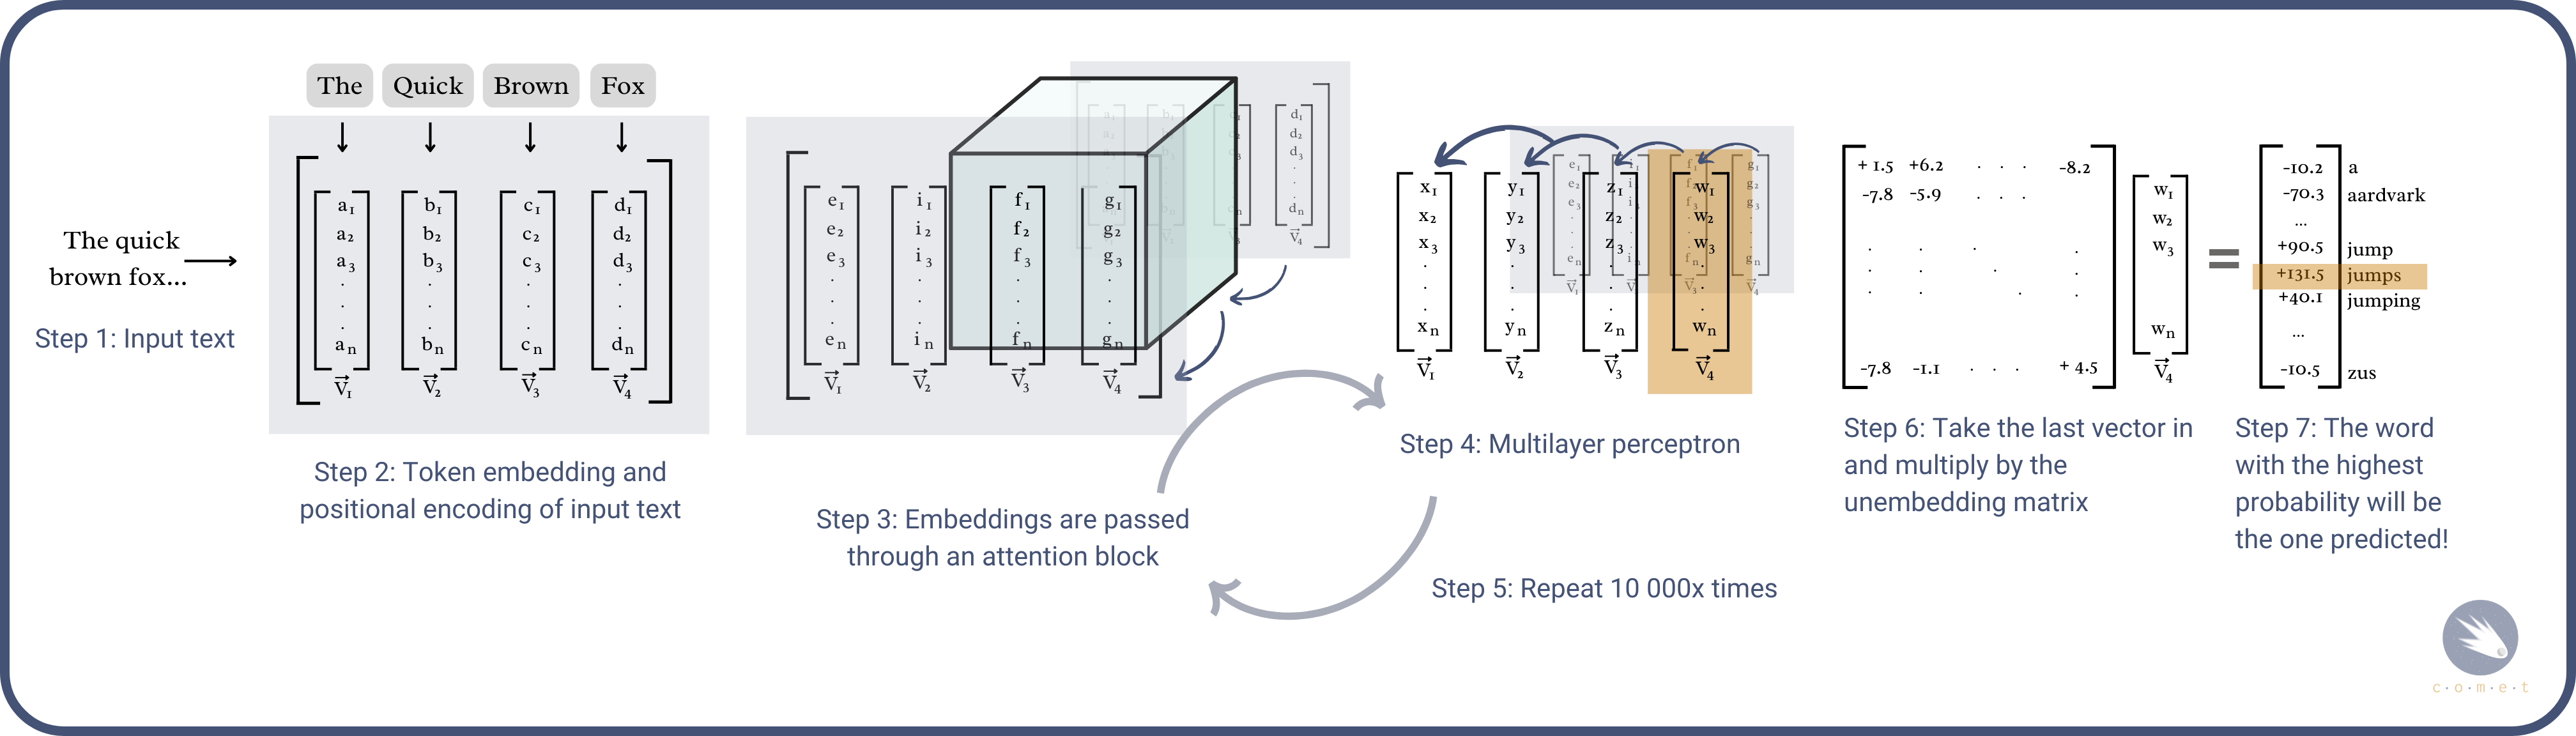

**3) Multi-layer perceptron/feed-forward network:** The multi-layer
perceptron, also called a feed-forward network, transforms complex
representations of input data by processing it through layers of
interconnected “neurons”. This transformation helps the network make
predictions, classify data, or generate meaningful outputs, using a
process called forward propagation. $^{[9]}$. Essentially, it allows the
model to map input data to desired outputs effectively. You can think of
the feed-forward network as asking a series of questions to the each
word in the input sequence $^{[10]}$. For instance, returning to the
previous example of *“The quick brown fox jumps over the lazy…”*, the
word “fox” could be asked the question “*are you a noun?*” and it’s
vector embedding would be updated accordingly.

This process is then repeated a number of times: the resulting vectors
are parsed through the attention mechanism, and then back into the feed
forward network. Each layer’s output becomes the input for the next
layer, gradually refining the data. The final layer, which corresponds
to the last feed-forward network, produces the network’s prediction. For
text generation tasks, this would be take the form of a probability
distribution $^{[10]}$.

**4) Unembedding matrix:** The last step multiplies the very last vector
in the result of the feed-forward network by a special matrix called the
*unembedding matrix*. The result of this multiplication results in a new
matrix, for which each entry corresponds to each word in the english
language. The values within this vector correspond to the respective
probabilities of each word being the correct “next” word $^{[10]}$
$^{[11]}$.

### 1.3 Weights, Weight Matrices, and Fine-tuning

**Weights:** Weights are parameters within a neural network that are
learned during the training process. They determine the strength and
direction of the connections in the network $^{[12]}$. Intially, weights
are set randomly; during training, the weights are adjusted to minimize
the error between the predicted output and the actual output, by
minimizing a loss function. This process is known as *gradient descent*
$^{[10]}$ $^{[13]}$.

**Weight matrices** are structured collections of weights arranged in
matrix form. They represent the connections between layers in a neural
network. The operation of passing inputs through the network involves
matrix multiplication: the input vector is multiplied by the weight
matrix to produce the output vector for the next layer $^{[14]}$.

In the attention mechanism, each word in the input sequence is
transformed into three different vectors: the query vector (used to
search for relevant information from other words in the sequence), the
key vector (represents the words in the sequence and is used to match
with query vectors), and the value vector (holds the actual information
of the words in the sequence and is used to generate the output of the
attention mechanism), using separate weight matrices $^{[14]}$. For
example, if the input is a sequence of words represented as vectors, the
queries, keys, and values are computed as:

$$Q=W_{Q}(X), K=W_{K}(X), V=W_{V}(X)$$

where $W_{Q}$​, $W_{K}$​, and $W_{V}$​ are weight matrices $^{[14]}$
$^{[15]}$. These vectors are used to calculate attention scores, which
determine how much focus each word should give to every other word in
the sequence.

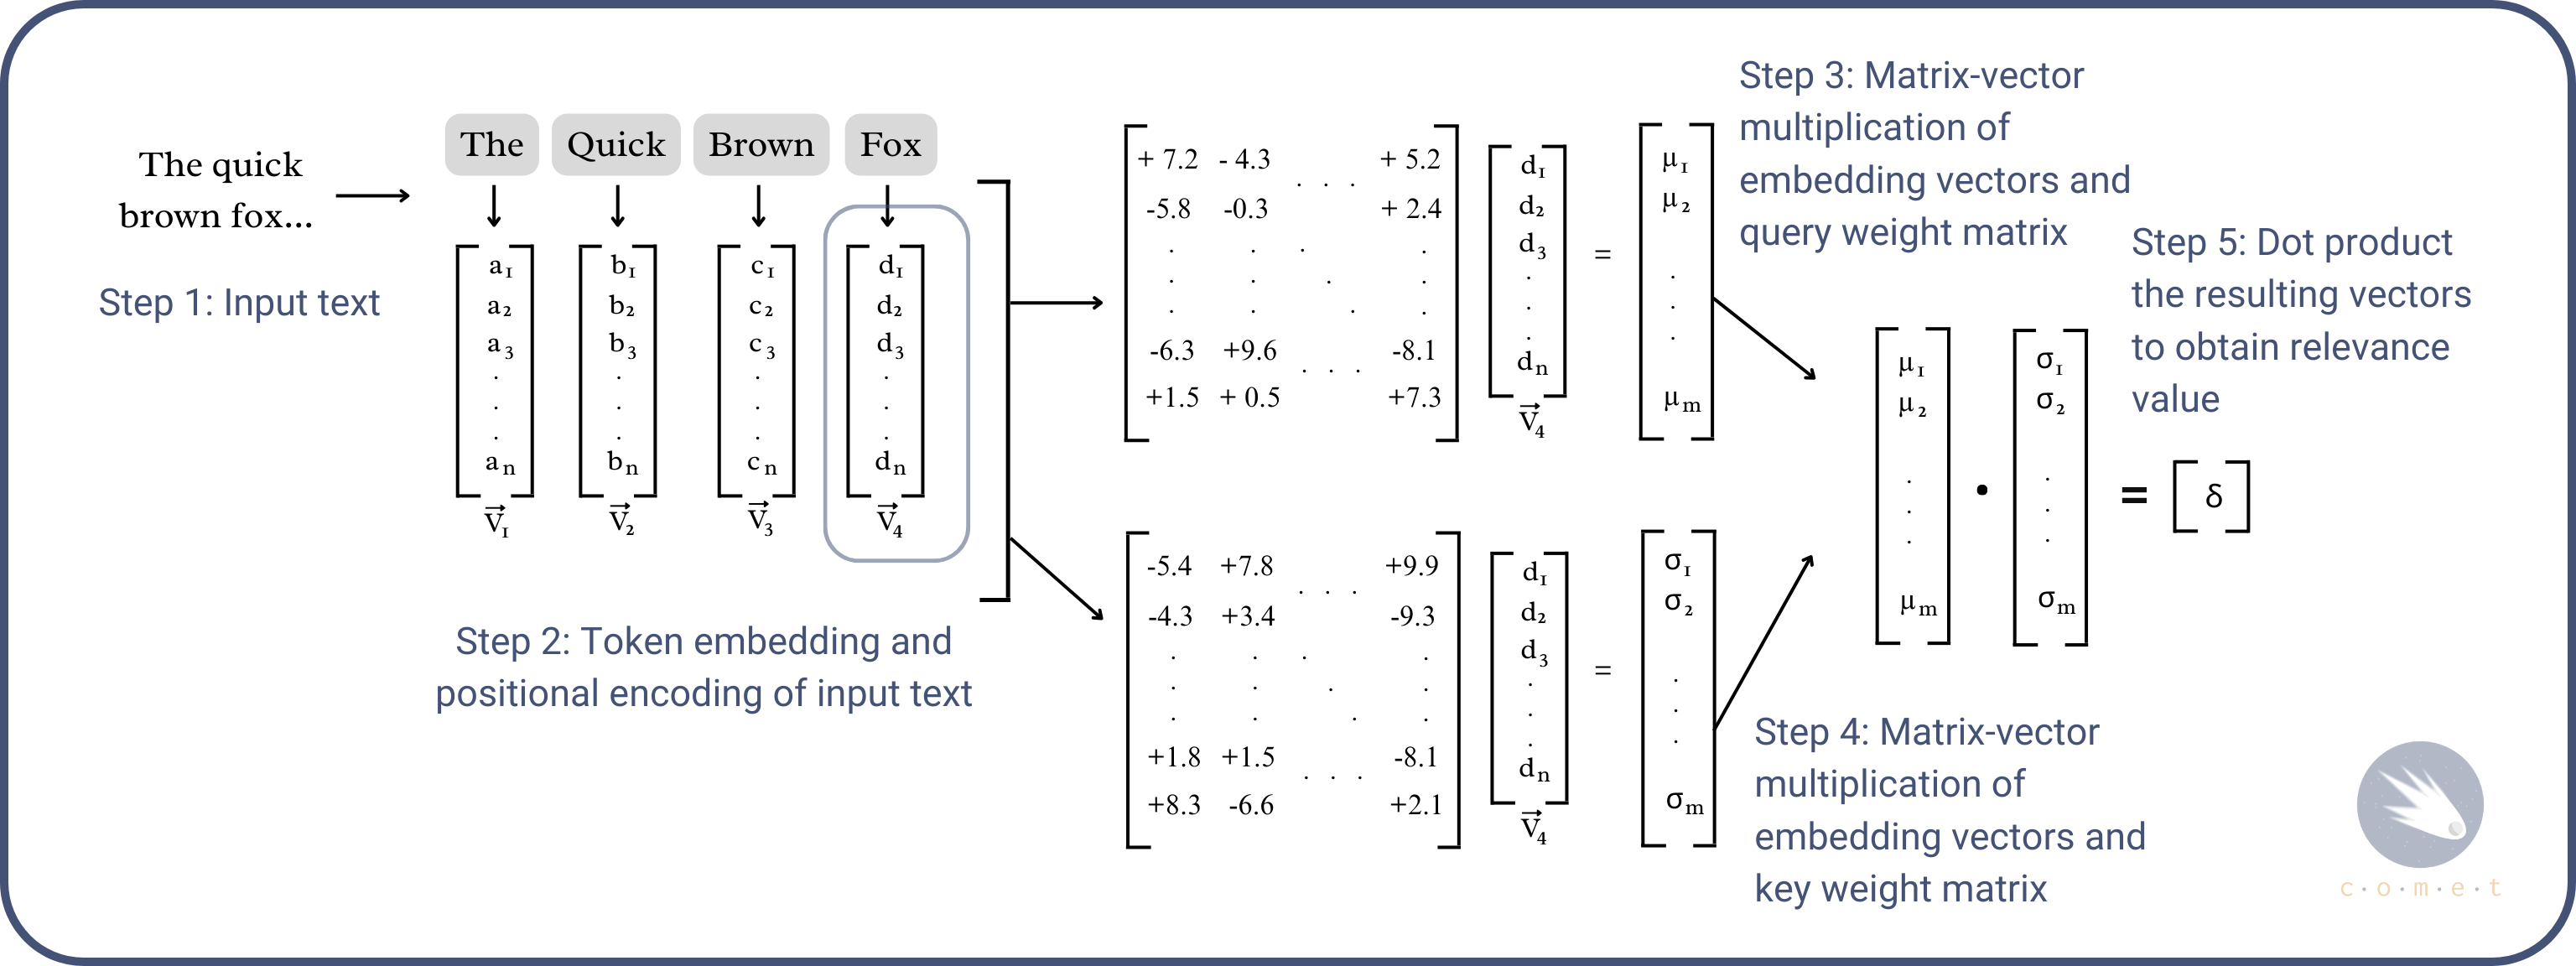

**Fine-tuning** is the process of updating the key, query and value
matrices to reflect new data $^{[16]}$. Because the weight matrices
contain both the original, general weights and the new adjustments from
the fine-tuning process, fine-tuning allows the model to retain the
broad, general knowledge from the pre-training phase while specializing
in the a new task, such as sentiment analysis, customer feedback, etc.

### 1.4 Bidirectional VS left-right encoding models

Model LLMs can be grouped into two categories: Those that have
bidirectional encoders, and left-right encoders. Left-right encoder
models are models that process text sequentially, at any given point in
the encoded text sequence, the model can only use information from the
current and previous tokens, not future tokens $^{[17]}$. For instance,
when processing the text “The quick brown fox jumps over the lazy dog”,
a left-right encoder processing the word “fox” would only have access to
the words “the”, “quick” and “brown” when assigning how much attention
should be paid to the word “fox”.

Bidirectional encoder models, on the other hand, process the input
sequence in both directions, from start to end and from end to start.
This allows the model to take into account both the left and right
context of each token simultaneously $^{[18]}$. This makes bidirectional
encoder models particularly strong at sentiment analysis tasks, as they
are better able to capture the sentiment assigned to each given word
$^{[19]}$.

**For this reason, if you wish to use large language models for
sentiment analysis, it’s recommended you use bi-directional encoder
models for both greater accuracy and faster training speeds.**

Some popular models include:

-   [Finbert](https://huggingface.co/ProsusAI/finbert) (For analyzing
    financial sentiment)
-   [RoBERTa](https://huggingface.co/docs/transformers/en/model_doc/roberta)
-   [BERT](https://huggingface.co/google-bert/bert-base-uncased)
-   [distilBERT](https://huggingface.co/distilbert/distilbert-base-uncased)
    (used in this notebook)

### 1.4 Self tests

#### 1.4.1 Self-test 1

In the phrase “*The quick brown fox jumps over the lazy…*”, a left-right
encoding model reading the word “fox” would have access to the words
\_\_\_\_\_ when determining the word’s \_\_\_\_.

Assign your answer to an object called `answer_1` as a string in the
cell below. For instance, if I were to pick the non-existent option “Z”,
I would enter `answer_1 = "Z"`.

-   1.  “jumps”, “over”, “the”, and “lazy”. Relevance.
-   1.  “The”, “quick”, “brown”, “jumps”, “over”, “the”, and “lazy”.
        Vector embedding.
-   1.  “The”, “quick”, and “brown”, Vector embedding.
-   1.  “jumps”, “over”, “the”, and “lazy”. Vector embedding.
-   1.  “The”, “quick”, and “brown”, Relevance.
-   1.  “The”, “quick”, “brown”, “jumps”, “over”, “the”, and “lazy”.
        Relevance.

In [1]:
#input your answer here

In [2]:
import hashlib
from hashlib import sha256

h=hashlib.new("SHA256")
h.update(answer_1.encode())
if str(h.hexdigest()) == "a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0e22207b8981233ec58":
    print("correct! \U0001f600")
else: print("incorrect, recall the the difference between left-right and bidirectional encoder models.")

In [3]:
correct = "C"
h=hashlib.new("SHA256")
h.update(correct.encode())
h.hexdigest()

#### 1.4.2 Self Test 2

Suppose an LLM was given the following text and tasked to perform
sentiment analysis: “It’s a beautiful sunny day outside”. It’s first
take would be to **embed** each word. Which of the following is a
reasonable embedding for the word “sunny”?

-   1.  isjfk29ndlsavbm4_2u3n
-   1.  ” sun-ny ”
-   1.  \<3820.2, 38573.6, 1826.2, 23.3, … 4958.3\>
-   1.  🌞

Assign your answer to an object called `answer_2` as a string in the
cell below. For instance, if I were to pick the non-existent option “Z”,
I would enter `answer_2 = "Z"`.

In [4]:
#input your answer here

In [5]:
import hashlib
from hashlib import sha256

h=hashlib.new("SHA256")
h.update(answer_2.encode())
if str(h.hexdigest()) == '6b23c0d5f35d1b11f9b683f0b0a617355deb11277d91ae091d399c655b87940d':
    print("correct! \U0001f600")
else: print("incorrect, recall that embeddings have both magnitude and direction.")

## 2. Setting up

Before we begin, we’ll need to create a new python environment for our
required libraries, as well as install CUDA.

### 2.1 Creating an envrionment

**Skip this step if you are using Google Collab.**

Let’s first create a python environment, using conda.

1.  Make sure you have miniconda installed, and open up the miniconda
    prompt.

2.  In the miniconda prompt, enter
    `conda create -n llm_finetuning jupyter`. This will create a new
    environment called llm_finetuning, with jupyter installed.

3.  Next, activate the environment by typing
    `conda activate llm_finetuning`.

### 2.2 Installing CUDA

We’ll now need to install CUDA. CUDA is a parallel computing platform
that allows computers with NVIDIA GPUs to harness their GPUs for tasks
other than graphics rendering (NVIDIA, 2024). This is essential for
running LLMs, which require loading in massive amounts of data
simultaneously. **For this reason, if you do not have access to an
NVIDIA GPU, you will not be able to run this notebook.**

Head to [CUDA toolkit
12.1](https://developer.nvidia.com/cuda-12-1-0-download-archive) and
follow the on-screen prompts to install it. **Note that pytorch requires
this specific version of CUDA. If you have a different version already
installed, you may need to uninstall it using `conda remove cuda` or
using the windows app installation menu.**

### 2.3 Installing required libraries

We can now install the required libraries.

1.  The first library we’ll need to install is pytorch: pytorch is an
    open-source deep learning framework for building deep learning
    models (NVIDIA, 2024). You can install pytorch using
    `conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia`.

2.  Additionally, we’ll need to install the transformers library. The
    transformers library is an open-source framework for deep-learning
    models, which provides access to useful APIs and pre-trained models
    (Huggingface, 2024). At the same time, we will install the datasets,
    accelerate, peft, optimum and bitsandbytes libraries. We can install
    them using:

In [6]:
!pip install transformers datasets accelerate peft optimum bitsandbytes

The datasets library is a library that provides access to useful
datasets for training LLMs. The other libraries are extensions of the
transformers library that provide support for faster training and
quantization.

1.  Lastly, we’ll install the huggingface login library, which will
    allow us to use gated models uploaded to huggingface, as well as
    upload our own fine-tuned model. You can install it using:

In [7]:
!pip install huggingface_hub

1.  Finally, we’ll need to restart our kernel, so that it recognizes the
    installed libraries. if you are in VSCode, you can do so by pressing
    “restart” at the top of the screen. If you are in jupyterlab, you
    can do so by pressing the “restart the kernel” button at the top
    left of your screen.

### 2.4 Logging into huggingface

We’ll now log into huggingface directly in this notebook, which will
allow us to use BERT, as well as upload our own fine-tuned model.

1.  If you haven’t already, create an account at
    https://huggingface.co/join.

2.  Once your account is created, navigate to
    `settings (located at the top right corner of your screen) > Access Tokens > +Create new token`.
    Give your token a name, and select, under user permissions:

-   Read access to contents of all repos under your personal namespace
-   Read access to contents of all public gated repos you can access
-   Write access to contents/settings of all repos under your personal
    namespace

Lastly, press `create` and copy your token. Save it somewhere, such as
in a notepad.

1.  We can now log into huggingface, directly in this notebook. Run the
    following command, and input your token:

In [8]:
from huggingface_hub import login
login()

### 2.5 Creating a huggingface model card

After we train our model, we’d like to be able to save it on huggingface
and call it directly from there.

1.  In Hugginface, navigate to the top-right corner of your screen and
    press the circular account icon.

2.  Press `new model` and create a model card.

3.  Copy the model ID of the model card by pressing “copy model name to
    clipboard”.

## 3. Fine-tuning BERT on a given dataset

As our LLM example, we’ll use BERT. BERT is an open-source large
language model created by Goggle, Specifically, we’ll be using
distilBERT, a faster and smaller version of BERT created by the
HuggingFace team $^{[20]}$.

In [9]:
from datasets import load_dataset, DatasetDict
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BitsAndBytesConfig, TrainingArguments, Trainer, EarlyStoppingCallback, DataCollatorWithPadding
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model
import numpy as np
from typing import Dict, Any

### 3.1 Loading in the IMDB dataset

We’ll fine-tune this model on the imdb dataset $^{[21]}$, a dataset
containing 100 thousand movie reviews and their sentiment: either
negative or positive. For teaching purposes, we’ll use a sample of the
full dataset, which contains 2000 reviews. 1000 will be used for
training, and another 1000 will be used for predicting.

**Our goal is to fine-tune a model by training it on a collection of
movie reviews, such that is more accurately predicts the sentiment of
movie reviews compared to the base model.**

Let’s start by taking a look at the dataset:

In [10]:
from datasets import load_dataset
dataset = load_dataset('shawhin/imdb-truncated')

Now that we’ve loaded in the dataset, let’s take a closer look at it:

In [11]:
dataset

We can see that the dataset contains 2 splits: One for training, and one
for testing, each with 1000 rows. Let’s preview the hundredth row in the
training set:

In [12]:
dataset['train'][100]

We can see that it contains a movie review, as well as a corresponding
label. A label of 0 corresponds to a negative review, and a label of 1
corresponds to a positive review.

### 3.2 Defining tokenizer and metrics functions

Let’s define some functions required for the LLM to process and evaluate
our dataset.

#### 3.2.1 Tokenizer function

The first function is the tokenizer function, designed to tokenize our
data, ie, convert each movie review into tokens.

Inputs:

-   examples: A dictionary containing the text data that needs to be
    tokenized.
-   tokenizer: An instance of AutoTokenizer from the Huggingface
    library. This tokenizer is used to convert text into tokens that can
    be - processed by a transformer model.

Operation: The tokenizer is applied to the text data in
examples\[‘text’\]. The text is tokenized with the following parameters:

-   padding=“max_length”: Adjusts the length of the text data to a
    uniform size by adding extra tokens. Pads the sequences to the
    maximum length specified by max_length (512 tokens).
-   truncation=True: Truncates the sequences to ensure they are no
    longer than max_length.
-   max_length=512: Sets the maximum length of the tokenized sequences
    to 512 tokens.

Output:

-   A dictionary containing the tokenized text, ready for input into a
    transformer model.

In [13]:
def tokenize_function(examples: Dict[str, Any], tokenizer: AutoTokenizer) -> Dict[str, Any]:
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)

 #Tokenizes the input examples using the provided tokenizer.
    #Args:
        #examples (Dict[str, Any]): A dictionary containing text data to be tokenized.
        #tokenizer (AutoTokenizer): The tokenizer to be used for tokenizing the text.
    #Returns:
        #Dict[str, Any]: A dictionary with tokenized text.

#### 3.2.2 Computing accuracy function

This function calculates the accuracy of the model’s predictions.

Input: eval_pred: A tuple containing two elements:

-   logits: The unstandardized predictions from the model, ie, the
    labels assigned to the movie reviews *by the model*.
-   labels: The *true* labels for the data, ie, the labels assigned to
    the movie reviews *by humans*, contained within the dataset.

Operation:

-   The logits are converted to standardized predictions using a
    mathematical function called argmax.
-   The accuracy is computed by comparing the predictions to the true
    labels and calculating the mean of correct predictions.

Output: - A dictionary with a single key-value pair: {“accuracy”:
accuracy}, where accuracy is the computed accuracy of the model’s
predictions.

In [14]:
def compute_metrics(eval_pred: Any) -> Dict[str, float]:
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = np.mean(predictions == labels)
    return {"accuracy": accuracy}

#Computes accuracy metrics from evaluation predictions.
    #Args:
        #eval_pred (Any): A tuple containing logits and labels.
    #Returns:
        #Dict[str, float]: A dictionary with accuracy metrics.

### 3.3 Configuring and quantizing BERT

We’ll now configure the model in order to fine-tune it. This involves
the following steps:

1.  Specifying the model ID (in this notebook, we use BERT. You can use
    other LLMs.)

2.  Tokenizing the IMDB dataset and inserting padding tokens

3.  Quantizing the model using bitsandbytes

4.  Setting the parameters we wish to finetune using Lora

#### 3.3.1 Specifying the Model ID, tokenizing, and padding

In [15]:
model_id = "distilbert/distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.add_special_tokens({'pad_token': '[PAD]'}) #Adding the padding tokens

tokenized_datasets = dataset.map(lambda example: tokenize_function(example, tokenizer))

#### 3.3.2 Quantizing and configuring Lora

If we want to use a model as big as BERT without frying our computer,
we’ll need to *quantize* it. **Quantization** in machine learning is a
process of reducing the precision of the numbers used to represent a
model’s parameters, in order to decrease the model size and
computational requirements. This often involves converting 32-bit
floating-point numbers to lower precision formats like 16-bit or 8-bit
integers $^{[22]}$ $^{[23]}$. In other words, quantization is a
technique to reduce the number of bits used to represent each parameter
in the model. Mathematically, quantization can be viewed as grouping
parameters into buckets. The issue with this is that multiple slightly
different parameters are now read as the same parameter!

<img src="quantization.png" width="500" height="340">

The primary benefit is faster inference and reduced memory usage, which
is especially advantageous for deploying models on resource-constrained
devices like laptops and computers designed for casual use $^{[23]}$.
Note that quantization can introduce some loss in model accuracy
$^{[24]}$., therefore, we want to avoid quantizing a model’s parameters
down too severely (such as to 2 bits).

We’ll quantize our model using the bitsandbytes library, provided by
huggingface:

-   **load_in_4bit=True:** This parameter specifies that the model
    should be loaded using 4-bit quantization.
-   **bnb_4bit_use_double_quant=True:** This parameter indicates the use
    of double quantization for the 4-bit quantized model. Double
    quantization is an additional step that can further compress the
    model weights, typically resulting in better compression ratios and
    sometimes improved performance.
-   **bnb_4bit_quant_type=“nf4”:** This specifies the type of
    quantization to use, in this case, 4-bit NormalFloat (nf4).
-   **bnb_4bit_compute_dtype=torch.bfloat16:** This sets the computer
    number format to be used for computations to bfloat16. bfloat16 is a
    16-bit floating-point data type that is often used in machine
    learning to reduce memory usage while maintaining numerical
    stability and performance, especially on hardware that supports it
    (Wikipedia, NA).

In [16]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

Let’s now load our model, and prepare it for training:

-   **model = AutoModelForSequenceClassification.from_pretrained(…):**
    This loads our model into our notebook, while specifying it’s
    quantization and usage for sequence classification.
-   **model.gradient_checkpointing_enable():** This function enables
    gradient checkpointing for the model. Gradient checkpointing is a
    technique to reduce memory usage during training.
-   **prepare_model_for_kbit_training:** This function prepares the
    model for training with quantization.

In [17]:
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2, quantization_config=bnb_config, device_map={"":0})
 # This function loads a pre-trained model for sequence classification.
    # model_id is the identifier for the pre-trained model.
    # num_labels=2: This specifies that the model will perform classification with 2 labels (binary classification).
    # quantization_config=bnb_config: This applies the previously defined quantization configuration (bnb_config) to the model, which includes loading the model in 4-bit quantization, using double quantization, etc.
    # device_map={"cuda"}: This maps the model to your GPU.

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

Next, we’ll need to set up LoRA. **LoRA (Low-Rank Adaptation)** is a
highly efficient method of fine-tuning, which involves adding
**adapters**, trainable additional parameters to the model. Then, when
training the model, we’d freeze all other parameters, and only train the
additional adapters, thus greatly decreasing training time.

In [18]:
config = LoraConfig(
        lora_alpha=64, # This is a scaling factor for the LoRA layers.
        lora_dropout=0.05, #This helps prevent overfitting of the model to the data.
        r=4, #This is the rank of the low-rank matrices. It determines the size of the additional trainable parameters. A lower rank means fewer parameters and less memory usage.
        bias="none",
        task_type="SEQ_CLS",
        target_modules=[
        "q_lin", "k_lin", "v_lin", "out_lin",  # Attention layers
        "lin1", "lin2"  # Feed-forward network layers
    ]
)
model = get_peft_model(model, config)

### 3.4 Training arguments

Additionally, we’ll need to set our training arguments. These arguments
tell the trainer how exactly to train the model. There are many training
arguments, and a full list can be found
[here](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.TrainingArguments).
All of these, except the first, are optional, but help reduce training
time.

output_dir=“yourname/yourmodel” is required and saves the trained model
to your huggingface account. <b>Make sure you specify the correct output
directory, which is the model name of the model card we created at the
start of this notebook.

In [19]:
from transformers import TrainingArguments, Trainer
import numpy as np

# Define the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",  # Set save strategy to match evaluation strategy
    learning_rate=2e-5,
    per_device_train_batch_size=1,  # Lower batch size to save memory
    per_device_eval_batch_size=1,  # Lower evaluation batch size to save memory
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=1,  # Only save the most recent model
    load_best_model_at_end=True,
    gradient_accumulation_steps=2,  # Accumulate gradients over 2 steps
    fp16=True,  # Enable mixed precision training
)

### 3.5 Creating a trainer instance and training the model

Let’s create a instance of the trainer which we’ll use to train the
model. Additionally, we’ll specify a padding object that will handle the
padding of the input sequences, using the tokenizer.

In [20]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model, # Specifies the model to be trained.
    args=training_args, # Provides the training arguments.
    train_dataset=tokenized_datasets["train"], # Specifies the training dataset.
    eval_dataset=tokenized_datasets["validation"],  # Specifies the testing dataset.
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics, # specifies the accuracy metric function
    data_collator=data_collator,  # Adds the data collator
)

### 3.6 Training the model

Finally, we can train our model on the dataset. We’ll run the
`trainer.train` command, which will iteratively train our model on the
training set and evaluate it on the validation set. It will do so three
times, each time using the previous trained version on the testing and
validations sets.

Note that the code below may take a long time to run, depending on your
computer capabilities. On a GeForce RTX 3090 with 24 GB of VRAM,
training time was 50 minutes.

In [21]:
trainer.train()

Once the code below has run, you’ll see the model’s accuracy metrics on
both the training and testing set, which should progressively increase
with each cycle (epoch).

Here, we’ve only ran training for three epochs. Often times,
particularly if you want to actually use your model for inference, you
may need to train it over more cycles. You may ask *“How do I know when
to stop training the model?”* It’s important to note that running the
model over 400 epochs will not increase accuracy. In fact, it may lead
to a decrease in accuracy, by *overfitting* the model on the training
set. Imagine studying for an exam: **overfitting** a model can be
thought of as memorizing the solution to each practice question in the
practice final instead of understanding the material. You might be great
at solving questions from the practice final, but chances are, you’ll do
terrible on the exam! Instead, aim to stop training when the accuracy
values for the training and validation sets are equal.

Additionally, if the model’s accuracy on the training set is already
nearly 100%, you’re unlikely to get any significant improvements in
accuracy by continually running training cycles. If you have a low
validation accuracy, you may need to change your training arguments or
avoid quantizing the default model.

This code will provide evaluation metrics of the model’s accuracy on the
validation set.

In [22]:
po = trainer.predict(tokenized_datasets["validation"])
print(po.metrics)

## 4. Putting it all together: Analyzing financial sentiment around Gamestop stock using FinlBERT

The financial phrasebank is a dataset of 4845 english articles on global
finance, split up into sentences $^{[25]}$. We want to finetune FinBERT,
a model built on the BERT model specifically for financial sentiment
$^{[26]}$, on a section of this corpus, and then use it for inference by
having it predict the remainder of the corpus.

1.  Pulling the dataset and uploading it to huggingface
2.  Manually creating testing and training splits
3.  Fine-tuning the model on the dataset
4.  Applying it to a collection of gamestop-related sentences

### 4.1 Loading in the dataset and creating testing/training/inference splits

The first thing we’ll need to do is create splits for our data.
Currently, the financial sentiment is fully labeled by humans, meaning
that each text has a sentiment value attached to it. Let’s suppose we
only had sentiment labels for half the dataset, use those labels to
train our model, and then have the model predict the rest of the
sentiment values.

We’ll do this by creating two initial splits of the data: the first will
be our dataset used for training the model and validating it’s outputs,
while the second will contain no sentiment values. Those values will be
inferred by our fine-tuned model. Second, we’ll create two more splits
in our training/validation dataset: the first will contain our training
data, and the second will contain our validation data.

In [23]:
from sklearn.model_selection import train_test_split
import pandas as pd

file_path = 'all-data.csv'
data = pd.read_csv(file_path, encoding='latin1')

# Split the dataset into training/validation and inference sets
training_data, inference_data = train_test_split(data, test_size=0.5, random_state=42)


inference_data['sentiment'] = "" #removing the provided sentiment values, we want to generate our own!
inference_data.to_csv("inference_data.csv", index=False)

train_data, test_data = train_test_split(training_data, test_size=0.4, random_state=42)
train_data.to_csv("training_data.csv", index=False)
test_data.to_csv("testing_data.csv", index=False)

Let’s take a look at our new datasets:

In [24]:
print("# of rows inference:", len(inference_data))
print("#of rows validation", len(test_data))
print("#of rows training:", len(train_data))

We’ll also convert our datasets into a format that can be read by
huggingface libraries, and combine the testing and training datasets
into a dictionary, a data structure that stores data in key-value pairs.

In [25]:
label_map = {'neutral': 0, 'positive': 1, 'negative': 2}
train_data['label'] = train_data['sentiment'].map(label_map)
test_data['label'] = test_data['sentiment'].map(label_map)

train_dataset = Dataset.from_pandas(train_data)
test_dataset = Dataset.from_pandas(test_data)

dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

Let’s take a look at the first entry of this dictionary:

In [26]:
dataset["train"][0]

### 4.2 Fine-tuning the FinBERT model

We are now ready to fine-tune the finBERT model.

In [27]:
def tokenize_function(examples: Dict[str, Any], tokenizer: AutoTokenizer) -> Dict[str, Any]:
    return tokenizer(examples[' text'], padding="max_length", truncation=True, max_length=512)

def compute_metrics(eval_pred: Any) -> Dict[str, float]:
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = np.mean(predictions == labels)
    return {"accuracy": accuracy}

model_id = "ProsusAI/finbert"

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Tokenize the datasets
def tokenize_and_format(examples):
    tokenized = tokenizer(examples[' text'], padding="max_length", truncation=True, max_length=512)
    tokenized['label'] = examples['label']
    return tokenized

tokenized_datasets = dataset.map(tokenize_and_format, batched=True)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=3, quantization_config=bnb_config, device_map={"":0})

lora_config = LoraConfig(
    lora_alpha=64,
    lora_dropout=0.05,
    r=4,
    bias="none",
    task_type="SEQ_CLS", 
    target_modules=[
        "attention.self.query", "attention.self.key", "attention.self.value", "attention.output.dense",  # Attention layers
        "intermediate.dense", "output.dense"  # Feed-forward network layers
    ]
)

model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)

training_args = TrainingArguments(
    output_dir="test",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True
)

data_collator = DataCollatorWithPadding(tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer.train()

trainer.push_to_hub()

### 4.3 Running inference

We are now ready to run inference on our model, ie, have it generate
predictions on our unlabelled half of the financial sentiment dataset.
We’ll do so using transformers’ pipeline feature, which greatly
simplifies running LLMs for inference.

The code below will run inference on the inference_data.csv dataset, and
generate a new csv called “predictions” which will contain the labeled
texts.

In [28]:
from transformers import pipeline
import pandas as pd

inference_df = pd.read_csv('inference_data.csv')

# Load the pipeline with the fine-tuned model
model_path = 'IreneBerezin/test'  # Path to the saved model directory
classifier = pipeline('text-classification', model=model_path, tokenizer=model_path, device_map="cuda")

# Perform inference
def classify_text(text):
    return classifier(text)[0]['label']

# Apply the classification to each row in the DataFrame
inference_df['sentiment'] = inference_df['text'].apply(classify_text)

# Save the predictions to a new CSV file
inference_df.to_csv('predictions_inf.csv', index=False)

print("Inference complete. Predictions saved to predictions.csv")

## 6. Self-test: Poem_sentiment dataset

Your turn! The
[google-research-datasets/poem_sentiment](https://huggingface.co/datasets/google-research-datasets/poem_sentiment)
library is a huggingface library with 1100 extracts from poems. These
poems are grouped into four categories: positive, negative, mixed, and
no-impact (no emotion). Your task is to fine-tune distilBERT on this
dataset, then run inference on three poem extracts and see if you obtain
the correct sentiment.

The code for inference is provided below.

In [29]:
model_path = ' '  # Path to the saved model directory
classifier = pipeline('text-classification', model=model_path, tokenizer=model_path)

texts = ["Nothing cheers my day more than seeing your radiant face", 
         "The world was clouded in a dark sadness", 
         "The leaves are orange"]

results = classifier(texts)

for result in results:
    print(result)

## 7. Citations

1.  What are some common challenges or pitfalls of lexicon-based
    sentiment analysis? (2023, April 12). www.linkedin.com.
    https://www.linkedin.com/advice/1/what-some-common-challenges-pitfalls-lexicon-based

2.  What are Large Language Models? NVIDIA Glossary. (n.d.). NVIDIA.
    https://www.nvidia.com/en-us/glossary/large-language-models/

3.  What is NLP (Natural Language Processing)? IBM. (n.d.).
    https://www.ibm.com/topics/natural-language-processing

4.  Wikipedia contributors. (2024, June 30). Natural language
    processing. Wikipedia.
    https://en.wikipedia.org/wiki/Natural_language_processing#Neural_NLP\_(present)

5.  What are Transformers? - Transformers in Artificial Intelligence
    Explained. (n.d.). Amazon Web Services,
    Inc. https://aws.amazon.com/what-is/transformers-in-artificial-intelligence/

6.  Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L.,
    Gomez, A. N., Kaiser, L., & Polosukhin, I. (2017, June 12).
    Attention is all you need. arXiv.org.
    https://arxiv.org/abs/1706.03762

7.  Sarkar, A. (2023, May 19). All you need to know about ‘Attention’
    and ‘Transformers’ — In-depth Understanding — Part 1. Medium.
    https://towardsdatascience.com/all-you-need-to-know-about-attention-and-transformers-in-depth-understanding-part-1-552f0b41d021

8.  Kalra, R. (2024, February 8). Introduction to transformers and
    attention mechanisms. Medium.
    https://medium.com/@kalra.rakshit/introduction-to-transformers-and-attention-mechanisms-c29d252ea2c5

9.  Luhaniwal, V. (2023, May 5). Forward propagation in neural networks
    — Simplified math and code version. Medium.
    https://towardsdatascience.com/forward-propagation-in-neural-networks-simplified-math-and-code-version-bbcfef6f9250

10. 3Blue1Brown. (2024, April 1). But what is a GPT?  Visual intro to
    transformers \| Chapter 5, Deep Learning. YouTube.
    https://www.youtube.com/watch?v=wjZofJX0v4M

11. Rohrer, B. (2021, October 9). Transformers from Scratch.
    https://e2eml.school/transformers.html#attention

12. Weights and Biases in machine learning. (n.d.). H2O.ai.
    https://h2o.ai/wiki/weights-and-biases/

13. Trehan, D. (2021, December 14). Gradient descent explained - towards
    data science. Medium.
    https://towardsdatascience.com/gradient-descent-explained-9b953fc0d2c

14. 3Blue1Brown. (2024b, April 7). Attention in transformers, visually
    explained \| Chapter 6, Deep Learning \[Video\]. YouTube.
    https://www.youtube.com/watch?v=eMlx5fFNoYc

15. Serrano.Academy. (2023b, August 31). The math behind Attention:
    Keys, Queries, and Values matrices \[Video\]. YouTube.
    https://www.youtube.com/watch?v=UPtG_38Oq8o

16. Exploration of Parameters-efficient fine-tuning methods
    (LoRA/MoRA/DoRA) in LLM. (2024, June 14).
    https://towardsai.net/p/machine-learning/exploration-of-parameters-efficient-fine-tuning-methods-lora-mora-dora-in-llm

17. Siva, G. (2022, January 4). BERT — Bidirectional Encoder
    Representations from Transformer. Medium.
    https://gayathri-siva.medium.com/bert-bidirectional-encoder-representations-from-transformer-8c84bd4c9021

18. Uni-directional transformer VS bi-directional BERT. (n.d.). Stack
    Overflow.
    https://stackoverflow.com/questions/55114128/uni-directional-transformer-vs-bi-directional-bert

19. Mittal, H., & Garg, N. (2024). Comment Sentiment Analysis Using
    Bidirectional Encoder Representations from Transformers. SSRN
    Electronic Journal. https://doi.org/10.2139/ssrn.4770927

20. Huggingface Team. DistilBERT. (n.d.).
    https://huggingface.co/docs/transformers/en/model_doc/distilbert

21. Stanford. (n.d.). stanfordnlp/imdb.
    https://huggingface.co/datasets/stanfordnlp/imdb

22. What is quantization? \| How it works & applications. (n.d.). MATLAB
    & Simulink. https://www.mathworks.com/discovery/quantization.html

23. Quantization. (n.d.).
    https://huggingface.co/docs/optimum/en/concept_guides/quantization

24. Coelho, A. (2024, January 10). Quantization in LLMs: Why does it
    matter?
    https://blog.dataiku.com/quantization-in-llms-why-does-it-matter

25. Sentiment analysis for financial news. (2020, May 27). Kaggle.
    https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news

26. ProsusAI/finbert (n.d.). https://huggingface.co/ProsusAI/finbert